# k-Nearest

Nearest neighbors is one of the simplest predictive models there is. It makes no mathematical assumptions, and it doesn’t require any sort of heavy machinery. The only things it requires are:
• Some notion of distance
• An assumption that points that are close to one another are similar

Most of the techniques we’ll look at in this book look at the data set as a whole in order to learn patterns in the data. Nearest neighbors, on the other hand, quite consciously neglects a lot of information, since the prediction for each new point depends only on the handful of points closest to it.

In [30]:
from collections import Counter
import math, random
import matplotlib.pyplot as plt
import re
%matplotlib inline

## Favorite Languages

In [31]:
cities = [(-86.75,33.5666666666667,'Python'), (-88.25,30.6833333333333,'Python'),
          (-112.016666666667,33.4333333333333,'Java'), (-110.933333333333,32.1166666666667,'Java'), 
          (-92.2333333333333,34.7333333333333,'R'), (-121.95,37.7,'R'), (-118.15,33.8166666666667,'Python'), 
          (-118.233333333333,34.05,'Java'), (-122.316666666667,37.8166666666667,'R'), (-117.6,34.05,'Python'), 
          (-116.533333333333,33.8166666666667,'Python'), (-121.5,38.5166666666667,'R'), 
          (-117.166666666667,32.7333333333333,'R'), (-122.383333333333,37.6166666666667,'R'), 
          (-121.933333333333,37.3666666666667,'R'), (-122.016666666667,36.9833333333333,'Python'), 
          (-104.716666666667,38.8166666666667,'Python'), (-104.866666666667,39.75,'Python'), 
          (-72.65,41.7333333333333,'R'), (-75.6,39.6666666666667,'Python'), 
          (-77.0333333333333,38.85,'Python'),(-80.2666666666667,25.8,'Java'),(-81.3833333333333,28.55,'Java'), 
          (-82.5333333333333,27.9666666666667,'Java'),(-84.4333333333333,33.65,'Python'), 
          (-116.216666666667,43.5666666666667,'Python'),(-87.75,41.7833333333333,'Java'), 
          (-86.2833333333333,39.7333333333333,'Java'),(-93.65,41.5333333333333,'Java'),(-97.4166666666667,37.65,'Java'),
          (-85.7333333333333,38.1833333333333,'Python'),(-90.25,29.9833333333333,'Java'),(-70.3166666666667,43.65,'R'),
          (-76.6666666666667,39.1833333333333,'R'),(-71.0333333333333,42.3666666666667,'R'), 
          (-72.5333333333333,42.2,'R'),(-83.0166666666667,42.4166666666667,'Python'), 
          (-84.6,42.7833333333333,'Python'),(-93.2166666666667,44.8833333333333,'Python'), 
          (-90.0833333333333,32.3166666666667,'Java'),(-94.5833333333333,39.1166666666667,'Java'), 
          (-90.3833333333333,38.75,'Python'),(-108.533333333333,45.8,'Python'),(-95.9,41.3,'Python'), 
          (-115.166666666667,36.0833333333333,'Java'),(-71.4333333333333,42.9333333333333,'R'), 
          (-74.1666666666667,40.7,'R'),(-106.616666666667,35.05,'Python'),(-78.7333333333333,42.9333333333333,'R'), 
          (-73.9666666666667,40.7833333333333,'R'),(-80.9333333333333,35.2166666666667,'Python'), 
          (-78.7833333333333,35.8666666666667,'Python'),(-100.75,46.7666666666667,'Java'),(-84.5166666666667,39.15,'Java'),
          (-81.85,41.4,'Java'),(-82.8833333333333,40,'Java'),(-97.6,35.4,'Python'), 
          (-122.666666666667,45.5333333333333,'Python'),(-75.25,39.8833333333333,'Python'),
          (-80.2166666666667,40.5,'Python'),(-71.4333333333333,41.7333333333333,'R'),(-81.1166666666667,33.95,'R'), 
          (-96.7333333333333,43.5666666666667,'Python'),(-90,35.05,'R'),(-86.6833333333333,36.1166666666667,'R'), 
          (-97.7,30.3,'Python'),(-96.85,32.85,'Java'),(-95.35,29.9666666666667,'Java'),
          (-98.4666666666667,29.5333333333333,'Java'),(-111.966666666667,40.7666666666667,'Python'),
          (-73.15,44.4666666666667,'R'),(-77.3333333333333,37.5,'Python'),(-122.3,47.5333333333333,'Python'),
          (-89.3333333333333,43.1333333333333,'R'),(-104.816666666667,41.15,'Java')]
cities = [([longitude, latitude], language) for longitude, latitude, language in cities]

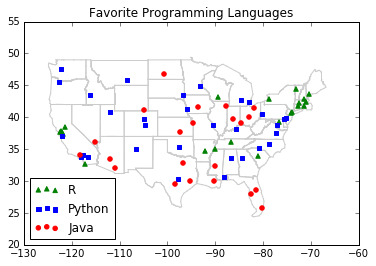

In [39]:
def plot_state_borders(plt, color='0.8'):
    segments = []
    points = []

    lat_long_regex = r"<point lat=\"(.*)\" lng=\"(.*)\""

    with open("../data/states.txt", "r") as f:
        lines = [line for line in f]

    for line in lines:
        if line.startswith("</state>"):
            for p1, p2 in zip(points, points[1:]):
                segments.append((p1, p2))
            points = []
        s = re.search(lat_long_regex, line)
        if s:
            lat, lon = s.groups()
            points.append((float(lon), float(lat)))
    for (lon1, lat1), (lon2, lat2) in segments:
        plt.plot([lon1, lon2], [lat1, lat2], color=color)

def plot_cities(cities):

    # key is language, value is pair (longitudes, latitudes)
    plots = { "Java" : ([], []), "Python" : ([], []), "R" : ([], []) }

    # we want each language to have a different marker and color
    markers = { "Java" : "o", "Python" : "s", "R" : "^" }
    colors  = { "Java" : "r", "Python" : "b", "R" : "g" }

    for (longitude, latitude), language in cities:
        plots[language][0].append(longitude)
        plots[language][1].append(latitude)

    # create a scatter series for each language
    for language, (x, y) in plots.items():
        plt.scatter(x, y, color=colors[language], marker=markers[language],
                          label=language, zorder=10)

    plot_state_borders(plt)    # assume we have a function that does this

    plt.legend(loc=0)          # let matplotlib choose the location
    plt.axis([-130,-60,20,55]) # set the axes
    plt.title("Favorite Programming Languages")
    plt.show()
    
plot_cities(cities)

In [33]:
import math

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))


def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
   return math.sqrt(squared_distance(v, w))

def majority_vote(labels):
    """assumes that labels are ordered from nearest to farthest"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest


def knn_classify(k, labeled_points, new_point):
    """each labeled point should be a pair (point, label)"""
    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                         key=lambda point_label: distance(point_label[0], new_point))
    # find the labels for the k closest
    k_nearest_labels = [label for _, label in by_distance[:k]]
    # and let them vote
    return majority_vote(k_nearest_labels)


for k in [1, 3, 5, 7]:
    num_correct = 0

    for location, actual_language in cities:

        other_cities = [other_city for other_city in cities if other_city != (location, actual_language)]

        predicted_language = knn_classify(k, other_cities, location)

        if predicted_language == actual_language:
            num_correct += 1

    print(k, "neighbor[s]:", num_correct, "correct out of", len(cities))

1 neighbor[s]: 40 correct out of 75
3 neighbor[s]: 44 correct out of 75
5 neighbor[s]: 41 correct out of 75
7 neighbor[s]: 35 correct out of 75


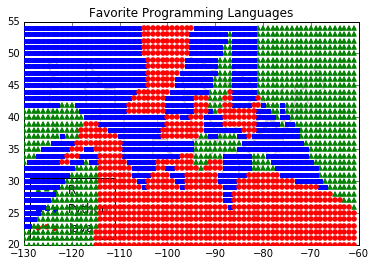

In [44]:
plots = { "Java" : ([], []), "Python" : ([], []), "R" : ([], []) }
k = 1 # or 3, or 5, or ...
for longitude in range(-130, -60):
    for latitude in range(20, 55):
        predicted_language = knn_classify(k, cities, [longitude, latitude])
        plots[predicted_language][0].append(longitude)
        plots[predicted_language][1].append(latitude)


kk_cities = []        
for key, value in plots.items():
    for long, lat in zip(value[0], value[1]):
        kk_cities.append(([long, lat], key))

plot_cities(kk_cities)